In [23]:
dict = {
    'derivation_I': 0,
    'derivation_II': 1,
    'derivation_III': 2,
    'derivation_avf': 3,
    'derivation_avl': 4,
    'derivation_avr': 5,
    'derivation_v1': 6,
    'derivation_v2': 7,
    'derivation_v3': 8,
    'derivation_v4': 9,
    'derivation_v5': 10,
    'derivation_v6': 11 
}


liste_reference = ['derivation_I', 'derivation_II', 'derivation_III']
induit = 'derivation_III'


{'fs': 500, 'sig_len': 1000, 'n_sig': 3, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV'], 'sig_name': ['i', 'ii', 'iii'], 'comments': ['<age>: 51', '<sex>: F', '<diagnoses>:', 'Rhythm: Sinus bradycardia.', 'Electric axis of the heart: left axis deviation.', 'Left ventricular hypertrophy.', 'Left ventricular overload.', 'Non-specific repolarization abnormalities: posterior wall.']}


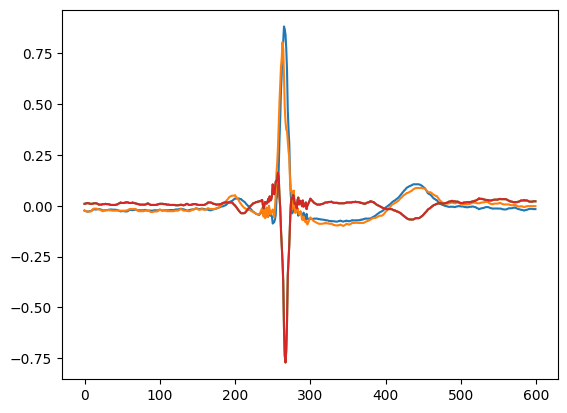

(600, 3)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import dipole as dip

"""
https://www.e-cardiogram.com/derivations-frontales-ou-standards/
"""
longueur = 600
imin = 400

signal, fields = wfdb.rdsamp('data/2/1',channels= [0, 1, 2], sampto=longueur + imin)
signal_test, _ = wfdb.rdsamp('data/2/1',channels= [2], sampto=longueur + imin)




signal = signal[imin:,:]
signal_test = signal_test[imin:,:]
plt.plot(signal)
plt.plot(signal_test)
print(fields)
plt.show()

# Dimension du corps

taille = 1.8
amplitude_bras = 0.8
hauteur_coeur = 1.5
epaisseur_tronc = 0.3
largeur_tronc = 0.4
hauteur_jambes = 0.7
epaisseur_bras = 0.1
epaisseur_jambe = 0.15

print(signal.shape)

In [25]:
# Fonction de perte

def loss_function(
        s : np.ndarray, # liste des différences de potentiels mesurées entre les électrodes 
        liste_derivation, # liste des couples de positions des électrodes
        c0 : np.ndarray, # position du coeur
        d0 : np.ndarray # dipole de référence
):
    loss = 0

    dipole = dip.Dipole(c0, d0)
    for i in range(len(s)):
        difference_potentiel = dipole.difference_potentiel(liste_derivation[i])
        loss += (difference_potentiel - s[i])**2
    
    return loss

# Gradient de la fonction de perte

def loss_gradient(
        s : np.ndarray, # liste des différences de potentiels mesurées entre les électrodes 
        liste_derivation, # liste des couples de positions des électrodes
        c0 : np.ndarray, # position du coeur
        d0 : np.ndarray # dipole de référence
):
    dipole = dip.Dipole(c0, d0)
    gradient = np.zeros(6)
    h = 1e-5
    for i in range(3):
        d1 = np.copy(d0)
        d2 = np.copy(d0)
        d1[i] += h
        d2[i] -= h
        gradient[i] = (loss_function(s, liste_derivation, c0, d1) - loss_function(s, liste_derivation, c0, d2))/(2*h)
    
    return gradient


# Descente de gradient

def descente_gradient(
        s : np.ndarray, # liste des différences de potentiels mesurées entre les électrodes 
        liste_derivation, # liste des couples de positions des électrodes
        c0 : np.ndarray, # position du coeur
        d0 : np.ndarray, # dipole de référence
        learning_rate : float,
        n_iter : int
):
    for i in range(n_iter):
        gradient = loss_gradient(s, liste_derivation, c0, d0)
        for j in range(3):
            d0[j] -= learning_rate*gradient[j]
    return d0

def plot_d0(d0,c ):
    #plt.arrow(0, 0, d0[0], d0[1], color = c)
    plt.plot(d0[0], d0[1], 'o', color = c)



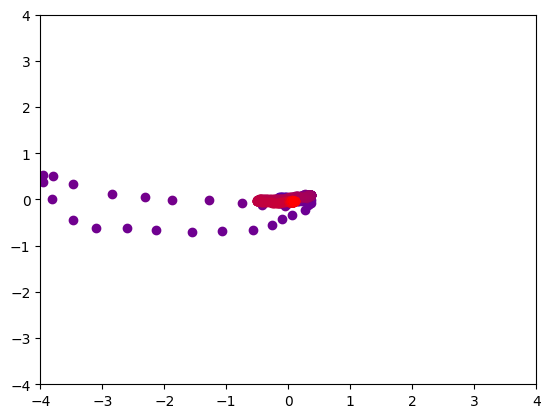

In [26]:
import numpy as np
from PIL import Image
# Test


poignet_gauche = dip.Vecteur(-0.3, 1 , 0)
poignet_droit = dip.Vecteur(0.3, 1 , 0)
cheville_gauche = dip.Vecteur(-0.3, 0.1 , 0)
cheville_droite = dip.Vecteur(0.3, 0.1 , 0)

c1 = dip.Vecteur(0, 1.3, 0.2)
c2 = dip.Vecteur(0.05, 1.3, 0.2)
c3 = dip.Vecteur(0.1, 1.3, 0.2)
c4 = dip.Vecteur(0.15, 1.3, 0.2)
c5 = dip.Vecteur(0.2, 1.3, 0.15)
c6 = dip.Vecteur(0.2, 1.3, 0.1)
E = dip.Vecteur(0, 1.3, 0.05)



derivation_I = dip.Derivation(poignet_droit, poignet_gauche)
derivation_II = dip.Derivation(poignet_droit, cheville_gauche)
derivation_III = dip.Derivation(poignet_gauche, cheville_gauche)
derivation_c1 = dip.Derivation(c1, E)
derivation_c2 = dip.Derivation(c2, E)

liste_derivation = [derivation_I, derivation_II, derivation_III]


c0 = np.array([0, hauteur_coeur, 0])
d0 = np.array([0, 0., 0])


    
# Create a list to store the frames
frames = []
potentiel = np.zeros((longueur, 2))
potentiel_test = np.zeros(longueur)

for i in range(longueur):
    print("     ", end='\r')
    print(i, end='\r')
    s = signal[i,:]
    d0 = descente_gradient(s, liste_derivation, c0, d0, 0.2, 20)
    dipole = dip.Dipole(c0, d0)
    for j in range(2):
        potentiel[i,j] = dipole.difference_potentiel(liste_derivation[j])
    potentiel_test[i] = dipole.difference_potentiel(derivation_III)
    plot_d0(d0, c = (i/longueur, 0, 1-i/longueur))
    r = 4
    plt.xlim(-r, r)
    plt.ylim(-r, r)
    
    # Save the current plot as an image
    plt.savefig(f'gif/frame_{i}.png')
    # Clear the current plot
    #plt.clf()
    # Append the image to the frames list
    frames.append(Image.open(f'gif/frame_{i}.png'))

# Save the frames as a GIF
frames[0].save('dipole_animation.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=10, loop=0)




plt.show()

[[-0.03759242 -0.04182824 -0.04357649 ... -0.00821136 -0.00821136
  -0.00821136]
 [-0.03759242 -0.04182824 -0.04357649 ... -0.00821136 -0.00821136
  -0.00821136]
 [-0.03515141 -0.03938723 -0.04113548 ... -0.00577035 -0.00577035
  -0.00577035]
 ...
 [-0.02538738 -0.02962319 -0.03137144 ...  0.00399369  0.00399369
   0.00399369]
 [-0.02538738 -0.02962319 -0.03137144 ...  0.00399369  0.00399369
   0.00399369]
 [-0.02538738 -0.02962319 -0.03137144 ...  0.00399369  0.00399369
   0.00399369]]


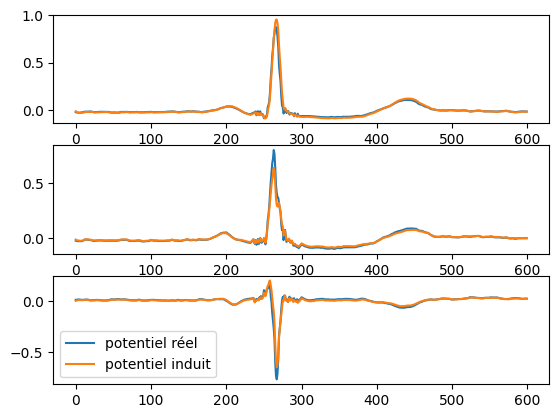

In [27]:
fig, ax = plt.subplots(3)

ax[0].plot(signal[:,0], label = 'potentiel réel')
ax[0].plot(potentiel[:,0], label = 'potentiel induit')

ax[1].plot(signal[:,1], label = 'potentiel réel')
ax[1].plot(potentiel[:,1], label = 'potentiel induit')

ax[2].plot(signal_test[:], label = 'potentiel réel')
ax[2].plot(potentiel_test[:], label = 'potentiel induit')

print(signal[:,0] + signal[:,1] + signal_test[:])
plt.legend()
plt.show()